# 🎓 Student Exam Performance Prediction — Full Project

**Dataset:** Student Success: Factors & Insights (Kaggle)

This Colab/Jupyter-ready notebook will:

- Load the dataset (from local CSV or Kaggle API)
- Perform Exploratory Data Analysis (EDA)
- Preprocess data (encoding, scaling, splitting)
- Train a Keras Feedforward ANN for regression
- Evaluate model performance and visualize results
- Show feature importance using SHAP (optional)
- Provide what-if simulations

Run cells in order. If you are using Google Colab and want to download directly from Kaggle, upload your `kaggle.json` and follow the instructions in the first cell.

## 0 — Colab: Kaggle setup (optional)

If you're in Google Colab and want to download the dataset directly, run this cell, upload `kaggle.json` when prompted, then run the Kaggle download command.

If you already uploaded the CSV into the environment, skip this cell and set the correct filename in the load cell.

In [2]:
# !pip install kaggle --quiet
# from google.colab import files
# uploaded = files.upload()  # upload kaggle.json here
# import os
# os.makedirs('/root/.kaggle', exist_ok=True)
# !cp kaggle.json /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# # Download dataset (file name may vary) - adjust command if necessary
# !kaggle datasets download -d anassarfraz13/student-success-factors-and-insights -p /content --unzip
print('If using Colab and Kaggle, uncomment and run the commands in this cell to download the dataset.')

If using Colab and Kaggle, uncomment and run the commands in this cell to download the dataset.


## 1 — Imports

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
print('Libraries imported')

Libraries imported


## 2 — Load dataset

Place the CSV in the environment or change the filename below to match the dataset file you downloaded from Kaggle.

In [1]:
# Update this filename if your CSV has a different name
# possible_files = [
#     '/content/StudentPerformanceFactors.csv',
#     '/content/student_success.csv',
#     'StudentPerformanceFactors.csv',
#     'student_success.csv',
#     'StudentSuccess.csv',
#     'StudentPerformance.csv'
# ]

# df = None
# for f in possible_files:
#     if os.path.exists(f):
#         df = pd.read_csv(f)
#         print('Loaded', f)
#         break

# if df is None:
#     raise FileNotFoundError('Dataset not found. Upload the CSV or update the filename in the notebook.')

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Path to the file inside the dataset
file_path = "StudentPerformanceFactors.csv"

# Load the latest version
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "anassarfraz13/student-success-factors-and-insights",
    file_path
)

print('Shape:', df.shape)
display(df.head())

/tmp/ipython-input-1347178143.py:28: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'student-success-factors-and-insights' dataset.
Shape: (6607, 20)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## 3 — Quick data overview

In [4]:
print('Columns:', df.columns.tolist())
print('\nInfo:')
display(df.info())
print('\nMissing values per column:')
print(df.isna().sum())
display(df.describe(include='all').T)

Columns: ['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Exam_Score']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607

None


Missing values per column:
Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hours_Studied,6607.0,NaN,NaN,NaN,19.975329,5.990594,1.0,16.0,20.0,24.0,44.0
Attendance,6607.0,NaN,NaN,NaN,79.977448,11.547475,60.0,70.0,80.0,90.0,100.0
Parental_Involvement,6607,3,Medium,3362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Access_to_Resources,6607,3,Medium,3319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extracurricular_Activities,6607,2,Yes,3938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep_Hours,6607.0,NaN,NaN,NaN,7.02906,1.46812,4.0,6.0,7.0,8.0,10.0
Previous_Scores,6607.0,NaN,NaN,NaN,75.070531,14.399784,50.0,63.0,75.0,88.0,100.0
Motivation_Level,6607,3,Medium,3351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Internet_Access,6607,2,Yes,6108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tutoring_Sessions,6607.0,NaN,NaN,NaN,1.493719,1.23057,0.0,1.0,1.0,2.0,8.0


## 4 — Exploratory Data Analysis (EDA)

In [5]:
# Identify numeric and categorical cols
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

print('Numeric cols:', numeric_cols)
print('Categorical cols (first 20):', cat_cols[:20])

Numeric cols: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']
Categorical cols (first 20): ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']


<Figure size 1200x600 with 0 Axes>

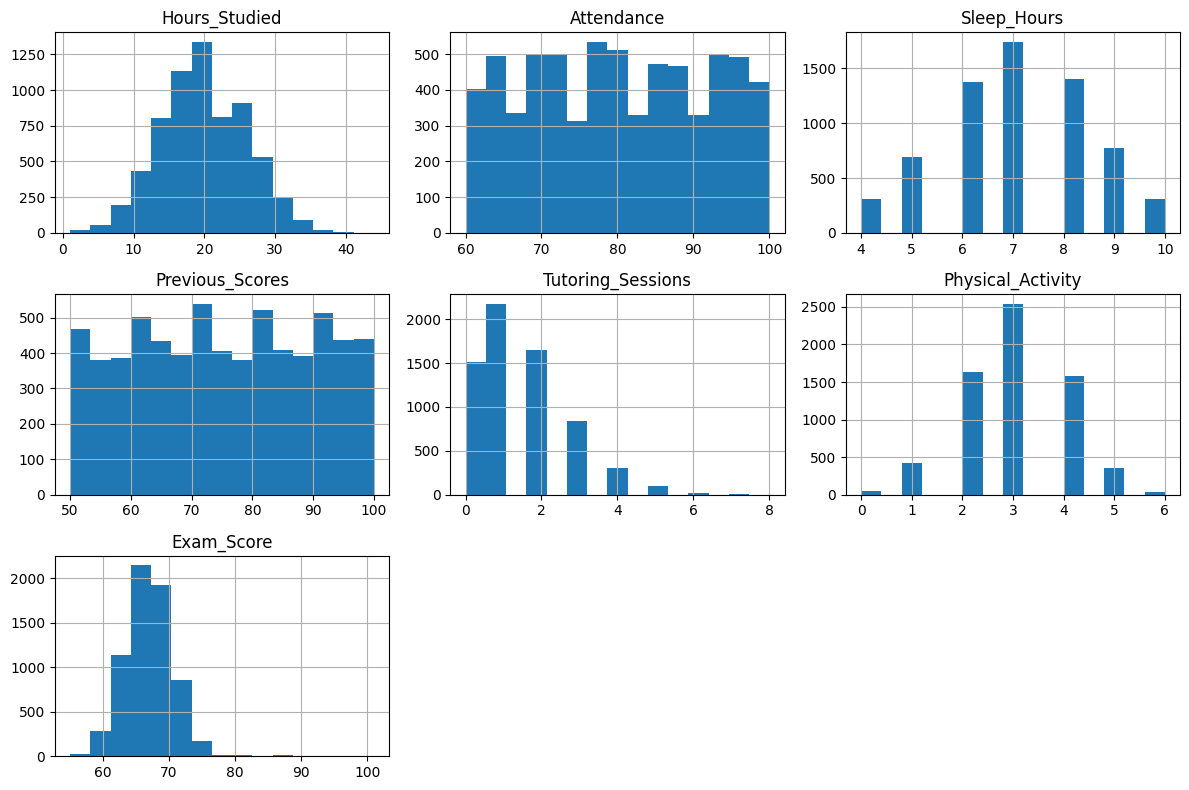

In [6]:
# Distribution of target candidates — show histograms for numeric cols
plt.figure(figsize=(12,6))
if len(numeric_cols)>0:
    df[numeric_cols].hist(bins=15, figsize=(12,8))
    plt.tight_layout()
else:
    print('No numeric columns found.')

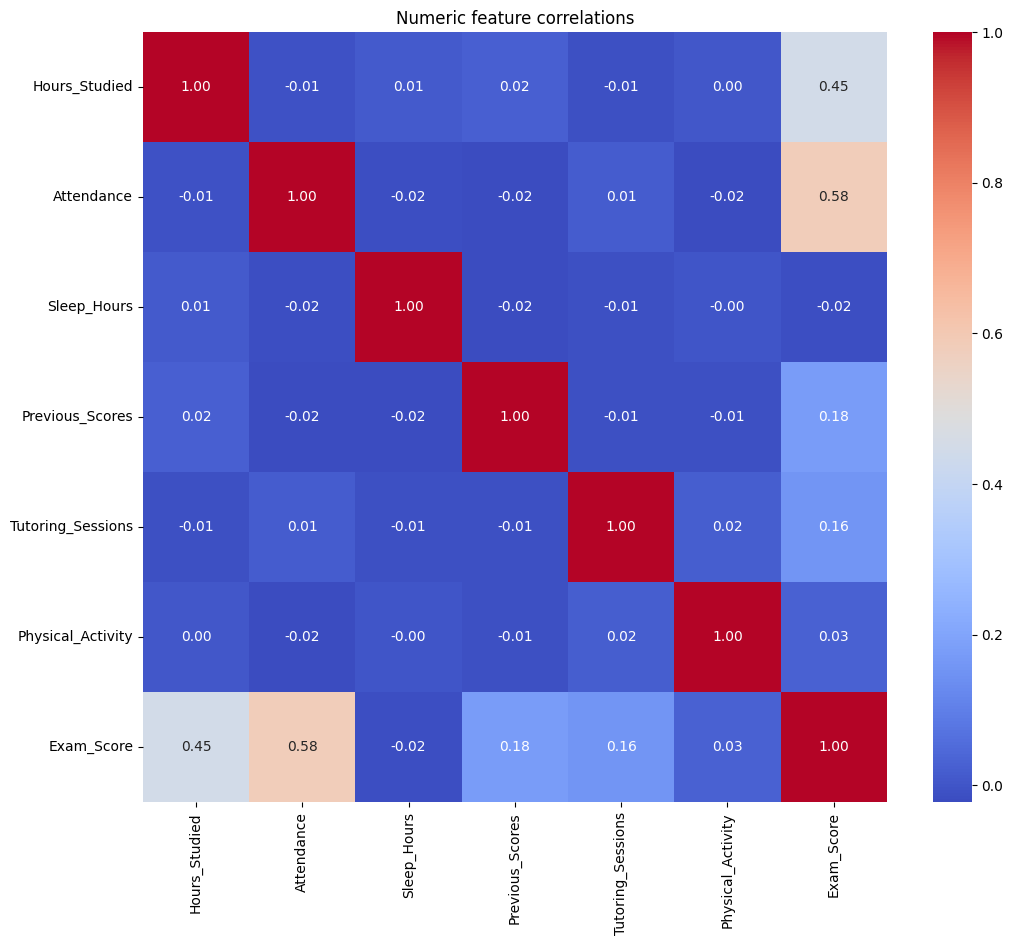

In [7]:
# Correlation heatmap for numeric columns
if len(numeric_cols) > 1:
    plt.figure(figsize=(12,10))
    sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Numeric feature correlations')
    plt.show()

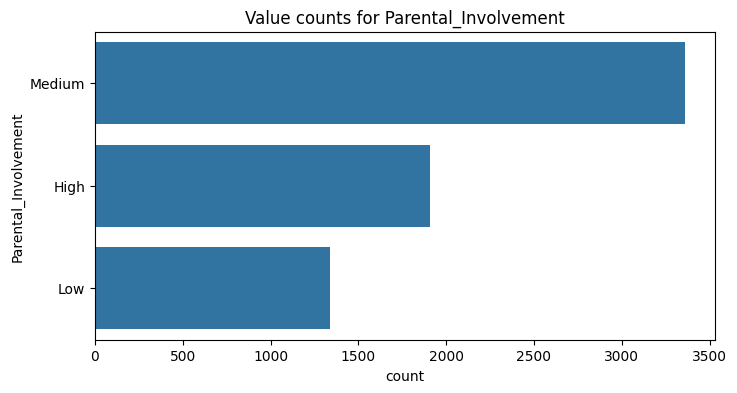

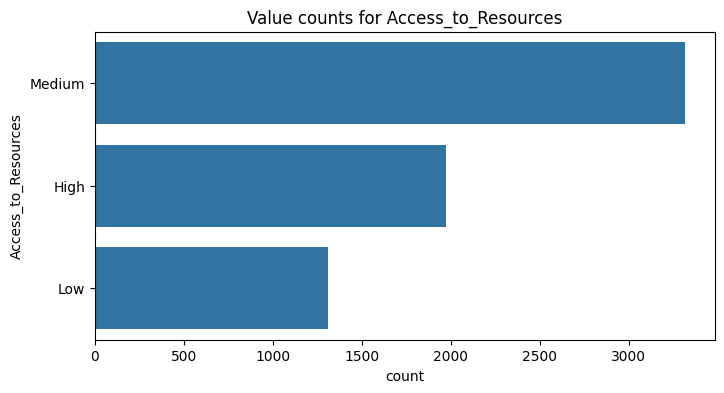

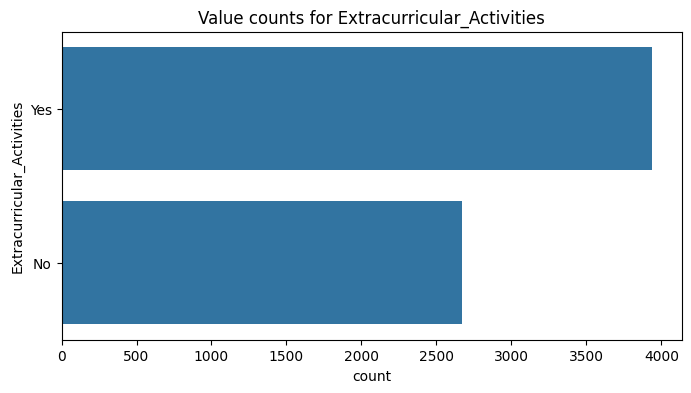

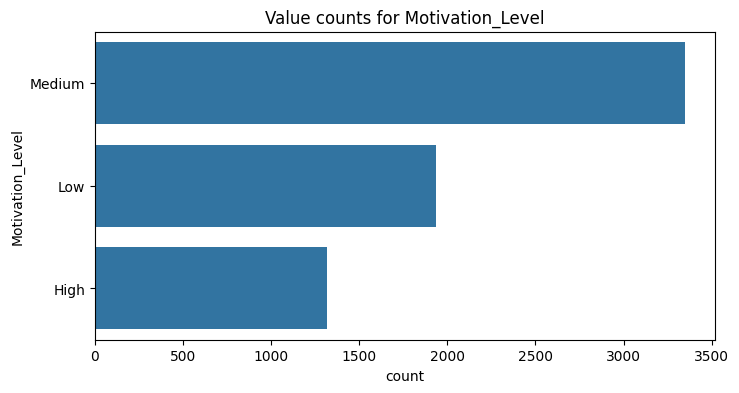

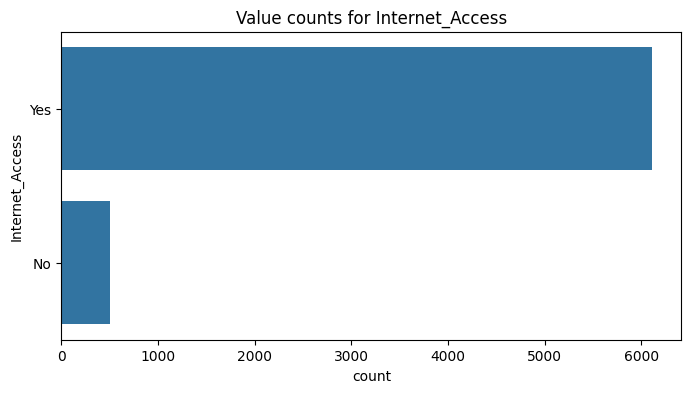

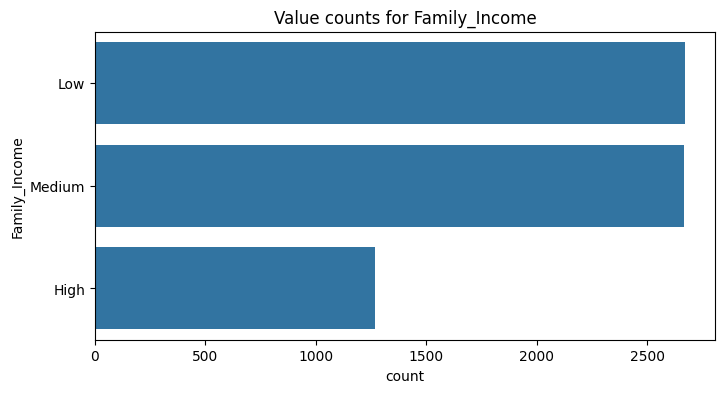

In [8]:
# Show counts for first few categorical columns
for col in cat_cols[:6]:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Value counts for {col}')
    plt.show()

## 5 — Choose target variable

The notebook will try to automatically infer the target (e.g., final grade or exam score). If it picks the wrong column, set `target` manually.

Auto-detected target: Exam_Score


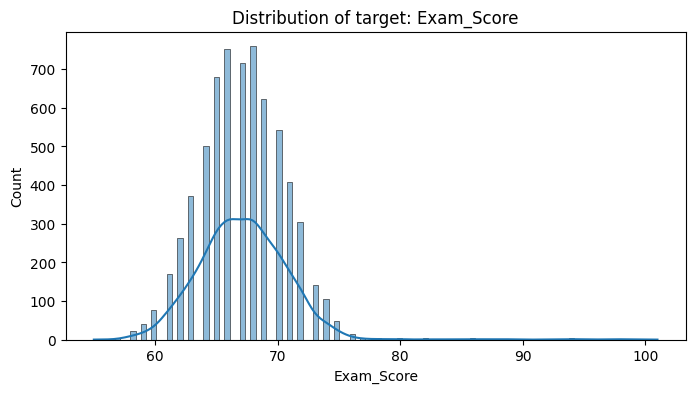

In [9]:
# Try to auto-detect common target column names
possible_targets = ['G3','FinalGrade','Exam_Score','Score','final_result','GPA','Total_Marks','Final_Marks','grade','marks']

target = None
for t in possible_targets:
    if t in df.columns:
        target = t
        break

# fallback: numeric column with 'final'/'grade'/'score' in name
if target is None:
    for c in df.columns:
        if any(k in c.lower() for k in ['final','grade','score','marks']):
            if np.issubdtype(df[c].dtype, np.number):
                target = c
                break

if target is None:
    # ask user to set target variable manually
    print('Could not auto-detect target column. Please set the variable `target` manually to the correct column name.')
else:
    print('Auto-detected target:', target)

# display target distribution
if target:
    plt.figure(figsize=(8,4))
    sns.histplot(df[target], kde=True)
    plt.title(f'Distribution of target: {target}')
    plt.show()

## 6 — Preprocessing

Steps:
- Drop columns with >50% missing values (if any)
- Fill missing numeric with median, categorical with mode
- One-Hot Encode categorical features (drop='first')
- Standard scale numeric features

In [10]:
# Drop columns with >50% missing values
thresh = len(df) * 0.5
df = df.dropna(thresh=thresh, axis=1)
print('Shape after dropping sparse cols:', df.shape)

Shape after dropping sparse cols: (6607, 20)


In [11]:
# Fill missing values: numeric -> median, categorical -> mode
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

if target in num_cols:
    num_cols_clean = [c for c in num_cols if c != target]
else:
    num_cols_clean = num_cols

for c in num_cols_clean:
    df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

print('Missing values after fill:')
print(df.isna().sum().sum())

Missing values after fill:
0


In [12]:
# Prepare X and y
if target is None:
    raise ValueError('Please set the target variable before preprocessing.')

X = df.drop(columns=[target])
y = df[target].astype(float)

# Recompute categorical and numeric lists based on X
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print('Final numeric cols:', num_cols)
print('Final categorical cols:', cat_cols)

Final numeric cols: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']
Final categorical cols: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']


In [13]:
# ColumnTransformer to OneHotEncode categorical columns and passthrough numeric
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# Fit-transform
X_enc = ct.fit_transform(X)
print('Encoded shape:', X_enc.shape)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Encoded shape: (6607, 27)
Train shape: (5285, 27) Test shape: (1322, 27)


## 7 — Build and train ANN model

In [14]:
# Build model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train
history = model.fit(X_train, y_train, validation_split=0.2, epochs=80, batch_size=32, verbose=1)

# Save model
model.save('student_score_ann_full.h5')
print('Model saved as student_score_ann_full.h5')

Epoch 1/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3056.1841 - mae: 50.8437 - val_loss: 30.9782 - val_mae: 4.0435
Epoch 2/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 48.4001 - mae: 5.5323 - val_loss: 24.0089 - val_mae: 3.4375
Epoch 3/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.0259 - mae: 4.9076 - val_loss: 19.2684 - val_mae: 2.9309
Epoch 4/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.0095 - mae: 4.7091 - val_loss: 18.2884 - val_mae: 2.8300
Epoch 5/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.3757 - mae: 4.5563 - val_loss: 15.3984 - val_mae: 2.4665
Epoch 6/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.2436 - mae: 4.3865 - val_loss: 15.0905 - val_mae: 2.4157
Epoch 7/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 31.0060 - mae: 4.3395 - val_loss: 14.1052 - val_mae: 2.2439
Epoch 8/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.9251 - mae: 4.1555 - val_loss: 12.4878 - val_mae: 1.9828
Epoch 9/80
133/133 ━━━━━━━━━━━━━━━━━━

Model saved as student_score_ann_full.h5


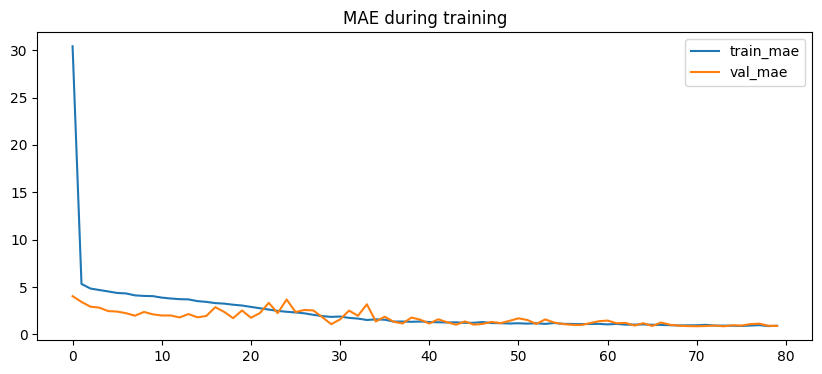

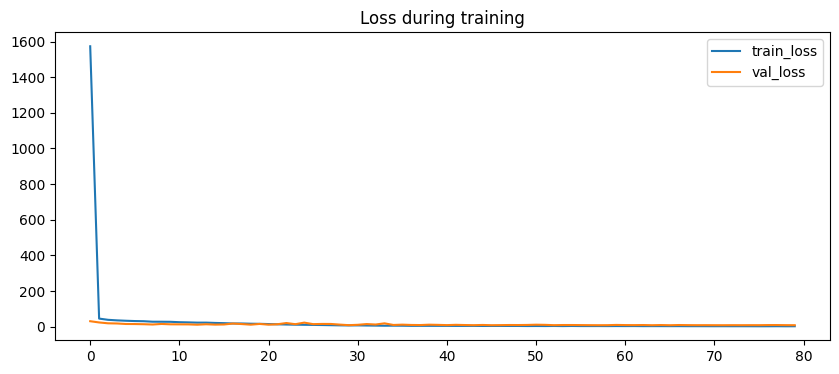

In [15]:
# Plot training history
plt.figure(figsize=(10,4))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend()
plt.title('MAE during training')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss during training')
plt.show()

## 8 — Evaluate on test set

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 0.7576803216054111
RMSE: 1.964481356547015
R2: 0.7269779120285962


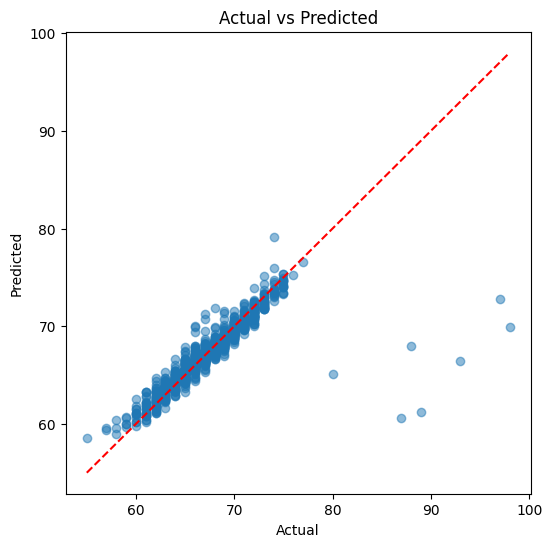

In [16]:
# Predictions and metrics
y_pred = model.predict(X_test).flatten()

print('MAE:', mean_absolute_error(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
print('RMSE:', mse ** 0.5)

print('R2:', r2_score(y_test, y_pred))

# Scatter plot actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

## 9 — Feature importance (SHAP) — optional

SHAP can be slow for neural networks. If you want to run it, install `shap` in Colab (`pip install shap`) and run the cell below. It uses KernelExplainer which can be slow; for faster results, consider TreeExplainer on tree models.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━

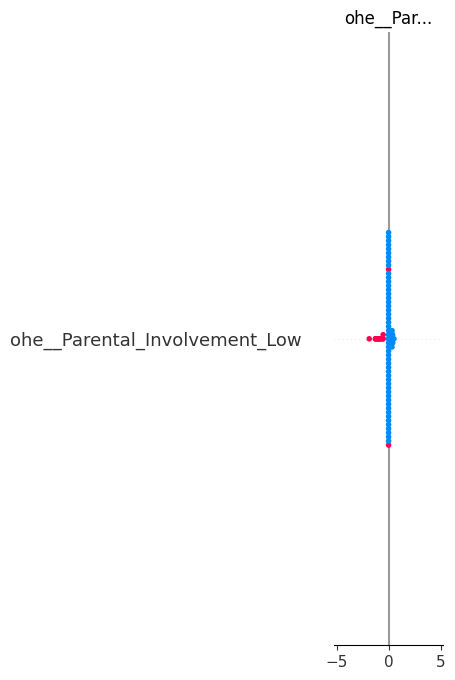

In [17]:
try:
    import shap
    # Use a small background set for KernelExplainer
    background = X_train[np.random.choice(X_train.shape[0], min(100, X_train.shape[0]), replace=False)]
    explainer = shap.KernelExplainer(model.predict, background)
    shap_vals = explainer.shap_values(X_test[:100], nsamples=100)
    feature_names = ct.get_feature_names_out()
    shap.summary_plot(shap_vals, X_test[:100], feature_names=feature_names)
except Exception as e:
    print('SHAP not installed or failed:', e)
    print('To enable SHAP, run: pip install shap and re-run this cell in Colab.')

## 10 — What-if simulations

Helper to transform a raw (pre-encoding) sample row, apply changes, and predict.

In [18]:
import numpy as np

# ---------- Helper prediction ----------
def predict_row(df_row):
    df_row = df_row.copy()

    # Ensure categorical columns are converted to string
    for c in cat_cols:
        df_row[c] = df_row[c].astype(str)

    Xr = ct.transform(df_row)
    Xr = scaler.transform(Xr)

    return float(model.predict(Xr).flatten()[0])


# ---------- Pick a sample ----------
orig_X = X.copy().reset_index(drop=True)

for c in cat_cols:
    orig_X[c] = orig_X[c].astype(str)

sample = orig_X.sample(1, random_state=42)

print("Original sample:")
display(sample.T)

print("Original prediction:", predict_row(sample))


# ---------- What-if modifications ----------
modifications = []

# Study hours related
for col in ['Hours_Studied']:
    if col in sample.columns:
        s2 = sample.copy()
        s2[col] = s2[col].iloc[0] + 3
        modifications.append((f"{col} +3", predict_row(s2)))

# Attendance
for col in ['Attendance']:
    if col in sample.columns:
        s2 = sample.copy()
        s2[col] = min(100, s2[col].iloc[0] + 10)
        modifications.append((f"{col} +10", predict_row(s2)))

# Motivation - Handle as categorical
# Define a mapping for motivation levels
motivation_level_map = {'Low': 'Medium', 'Medium': 'High', 'High': 'High'}
for col in ['Motivation_Level']:
    if col in sample.columns:
        current_motivation = sample[col].iloc[0]
        s2 = sample.copy()
        # Increment motivation level based on map, if possible
        if current_motivation in motivation_level_map:
            s2[col] = motivation_level_map[current_motivation]
            modifications.append((f"{col} (increased)", predict_row(s2)))
        else:
            # If it's a value not in map, just keep original for this simulation
            modifications.append((f"{col} (no change, unknown level)", predict_row(s2)))


# ---------- Output results ----------
print("\nWhat-if simulation results:")
for desc, val in modifications:
    print(desc, "->", round(val, 2))

Original sample:


,743
Hours_Studied,20
Attendance,71
Parental_Involvement,Medium
Access_to_Resources,Low
Extracurricular_Activities,No
Sleep_Hours,7
Previous_Scores,87
Motivation_Level,High
Internet_Access,Yes
Tutoring_Sessions,1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Original prediction: 65.17066955566406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

What-if simulation results:
Hours_Studied +3 -> 65.92
Attendance +10 -> 66.83
Motivation_Level (increased) -> 65.17


In [21]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
# Path to the file inside the dataset
file_path = "StudentPerformanceFactors.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "anassarfraz13/student-success-factors-and-insights",
    file_path
)
print(df.head())

Using Colab cache for faster access to the 'student-success-factors-and-insights' dataset.
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium